In [1]:
import pandas as pd 
import numpy as np
import zipfile
zip_ref = zipfile.ZipFile("/content/1part of training and testing set.zip", 'r')
zip_ref.extractall()

df_train=pd.read_csv('/content/a part of training and testing set/UNSW_NB15_training-set.csv')
df_test=pd.read_csv('/content/a part of training and testing set/UNSW_NB15_testing-set.csv')

#f1 = pd.read_csv("/content/data_identity.csv")
#df2 = pd.read_csv("/content/data_transaction.csv")


### Uploading + preprocessing

In [2]:
data=pd.concat([df_train,df_test],ignore_index=True)
y=data['label']
data.drop('label',axis=1,inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

#### Now check is our obj features contains a lot of text description or just category (in this case can use simple encoding)

In [4]:
obj = ["proto","service","state","attack_cat"] 
for ob in obj:
  print(len(np.unique(data[ob])))

133
13
11
10


### check our features consist of constant values or not (let's say treshhold is 93%)

In [5]:
import collections
from collections import Counter
percents_of_consist = []
for col in data.columns:
  # if len(np.unique(data[col]))==2:
  #   print (col )
  percents_of_consist.append(Counter( data[col]).most_common(1)[0][1]/len(data))

useless_col = np.where(np.array(percents_of_consist)>0.93)[0] 
data = data.drop(columns = data.columns[useless_col])

In [6]:
X_new  = pd.get_dummies(data)
percents_of_consist = []
for col in X_new.columns:
  # if len(np.unique(data[col]))==2:
  #   print (col )
  percents_of_consist.append(Counter( X_new[col]).most_common(1)[0][1]/len(X_new))

useless_col = np.where(np.array(percents_of_consist)>0.93)[0] 
data = X_new.drop(columns = X_new.columns[useless_col])


In [7]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data = scaler.fit_transform(data)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data, y, test_size=0.2, random_state=42)


### creation of custom dataset for training 



In [9]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from torch.autograd import Variable 
FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available()  else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if torch.cuda.is_available()  else torch.LongTensor 

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

x_tensor_train = torch.tensor(X_train).float()
x_tensor_test = torch.tensor(X_test).float()
y_tensor_train = torch.tensor(y_train.values).float()
y_tensor_test = torch.tensor(y_test.values).float()

train_dataset = CustomDataset(x_tensor_train,
                                y_tensor_train,
                               )

test_dataset = CustomDataset(x_tensor_test,
                               y_tensor_test,
                               )


### Here just set up parameters from paper for G and D - add DropOut to avoid overfitting

In [10]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, input_size):
        super(Generator, self).__init__()
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.input_size = input_size
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim + self.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            nn.Linear(512, self.input_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_embedding(labels), noise), -1)
        out = self.model(gen_input)
#         
        return out


class Discriminator(nn.Module):
    def __init__(self, n_classes, input_size):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.input_size = input_size
        self.label_embedding = nn.Embedding(self.n_classes, self.n_classes)

        self.model = nn.Sequential(
            nn.Linear(self.n_classes + self.input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, input, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((input, self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


### set up parameters

In [11]:
batchSize = 1000
learning_rate = 0.0005
num_epochs = 2000
input_dim=X_train.shape[1]
latent_dim = int(np.sqrt(input_dim))


generator = Generator(2, latent_dim, input_dim).to(device)
discriminator = Discriminator(2, input_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0005)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0005)
# print(summary(AE,input_size=(1, 64)))

adversarial_loss = torch.nn.MSELoss()

#Create a random dataset
#data_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), TensorDataset(torch.from_numpy(y_train) ),batch_size=batchSize,shuffle=True)
# del full_train

data_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

### Train on just few batches cause colab some limitations

In [15]:
from tqdm import tqdm
import torch.nn.functional as F
num_epochs = 20


losses = []
kl_divs = []
for epoch in tqdm(range(num_epochs)):
    epoch_losses = []
    epoch_kl_divs = []
    for i, (input_, target) in enumerate(tqdm(data_loader)):
        input_ = Variable(input_.type(FloatTensor)).to(device)
        target = Variable(target.type(LongTensor)).to(device)

        batch_size = input_.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, 2,batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(input_, target)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_losses.append(g_loss.item() + d_loss.item())
        epoch_kl_divs.append(F.kl_div(gen_imgs.detach().cpu(), input_.detach().cpu()))
        
    losses.append(np.mean(epoch_losses))
    kl_divs.append(np.mean(epoch_kl_divs))

100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


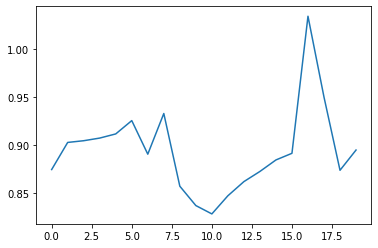

In [16]:
from matplotlib import pyplot as plt

plt.plot(losses) 



Yeah , losses not so good but remember we train just in 20 epoch , then author recommend to use 2000

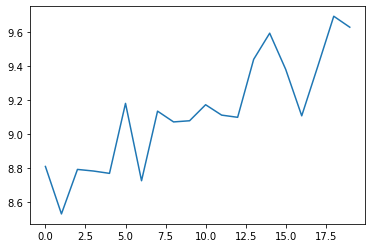

In [17]:
plt.plot(kl_divs) 

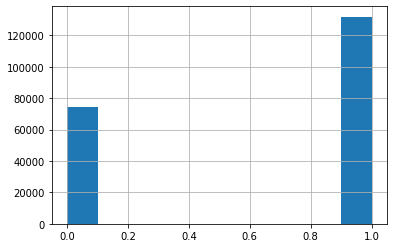

In [18]:
y_train.hist()


### So have some imbalance - generate some data for label 0 and compare result with begining dataset

In [19]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([ 74325, 131813]))

In [20]:
n_disbalanced = 131813 - 74325
n_disbalanced

57488

In [21]:
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.neural_network import MLPClassifier 

In [22]:
z = Variable(FloatTensor(np.random.normal(0, 1, (n_disbalanced, latent_dim))))
gen_labels = Variable(LongTensor(np.zeros(n_disbalanced)))

with torch.no_grad():
    # Generate a batch of images
    gen_outputs = generator(z, gen_labels).cpu().numpy()



extended_train_x = np.vstack((X_train, gen_outputs))
extended_train_y = np.hstack((y_train, np.zeros(n_disbalanced)))    

In [25]:
from sklearn.metrics import classification_report 

classes = [ RandomForestClassifier(), 
               ExplainableBoostingClassifier(),
                MLPClassifier(hidden_layer_sizes=(input_dim))] 
for class_ in classes:
    print(class_)
    class_.fit(X_train, y_train)
    y_pred = class_.predict(X_test)
    print(classification_report(y_test, y_pred))

RandomForestClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535

ExplainableBoostingClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535

MLPClassifier(hidden_layer_sizes=48)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00 

In [ ]:





print(classes[2])
classes[2].fit(extended_train_x, extended_train_y)
y_pred = classes[2].predict(X_test)
print(classification_report(y_test, y_pred))

In [36]:
y_pred = classes[2].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535



In [37]:
print(classes[0])
classes[0].fit(extended_train_x, extended_train_y)
y_pred = classes[2].predict(X_test)
print(classification_report(y_test, y_pred))
y_pred = classes[0].predict(X_test)
print(classification_report(y_test, y_pred))

RandomForestClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535



### Result:  so  actually our performance good without balanced ) and it diffucult compare it here but we can use less data for training ML models and check improvement